In [1]:
import csv
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from sklearn.metrics import confusion_matrix
import pandas as pd


In [5]:
#Load the labels from the two files

crowd_labels_file = '/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/data/clean_crowd_benchmark.csv'
expert_labels_file = '/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/data/expert/expertconsensus_superclass.csv'

Usefull functions

In [6]:
# This function takes four arguments: the x and y coordinates of the top-left corner of a bounding box (x1, y1), 
# the width (w), and the height (h) of the bounding box. It returns a list of four values: the x and y coordinates 
# of the top-left corner of the bounding box (x1, y1), and the x and y coordinates of the bottom-right corner of the 
# bounding box (x1 + w, y1 + h), in the format required by the Pascal VOC dataset.

def coco_to_pascal_voc(x1, y1, w, h):
    return [x1,y1, x1 + w, y1 + h]



In [15]:
# Define dictionaries to map class IDs to class names
class_map1 = {1: 'Crane', 2: 'Goose', 3: 'Duck'}
class_map2 = {1: 'Crane', 2: 'Goose', 3: 'Duck'}

# Read in the labels from file 1
crowd_labels = defaultdict(list)

with open(crowd_labels_file) as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip header
    for row in reader:
        if len(row)>0:
            label_id, filename, bbox, class_id = row
            bbox = [float(x) for x in bbox[1:-1].split(',')]
            bbox=coco_to_pascal_voc(*bbox)
            crowd_labels[filename].append((label_id, bbox, int(class_id)))


# # Read in the labels from file 2
expert_labels = defaultdict(list)
with open(expert_labels_file) as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip header
    for row in reader:
        if len(row)>0:
            label_id, filename, bbox, class_id = row
            filename=filename.replace('.JPG','')
            bbox = [float(x) for x in bbox[1:-1].split(',')]
            bbox=coco_to_pascal_voc(*bbox)
            expert_labels[filename].append((label_id, bbox, int(class_id)))


In [44]:
# Compute the confusion matrix

# Define the IOU threshold and read in the labels
iou_thresh = 0.20

# Initialize empty lists to store matching labels
truth_list=[]
test_list=[]

# Iterate through files that have labels from both experts and crowdworkers
for filename in set(crowd_labels.keys()) & set(expert_labels.keys()):
    
    # Check if the current file has labels from both sources
    if filename in crowd_labels and filename in expert_labels:
        
        # Iterate through each label from the expert
        for expert_label in expert_labels[filename]:
            
            # Iterate through each label from the crowdworker
            for crowd_label in crowd_labels[filename]:

                # Convert the bounding box coordinates into a shapely object
                bbox1 = box(*crowd_label[1])
                bbox2 = box(*expert_label[1])
                
                # Compute the intersection over union (IOU) between the two bounding boxes
                iou = bbox1.intersection(bbox2).area / bbox1.union(bbox2).area
                
                # If the IOU is above the threshold, consider the labels a "match" and add them to the list to compare expert with crowdworker.
                if iou >= iou_thresh:
                    truth_list.append(expert_label[2])
                    test_list.append(crowd_label[2])

# Compute a confusion matrix to evaluate the performance of the crowdworkers
conf_matrix=confusion_matrix(truth_list,test_list)


In [45]:
# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[  46    0    1]
 [   0  104   13]
 [   1    0 1407]]


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision
precision = precision_score(truth_list, test_list, average='macro')

# Compute recall
recall = recall_score(truth_list, test_list, average='macro')

# Compute F-1 score
f1 = f1_score(truth_list, test_list, average='macro')

print("Precision: ", precision)
print("Recall: ", recall)
print("F-1 score: ", f1)

Precision:  0.9979879275653923
Recall:  0.9696969696969697
F-1 score:  0.9831179023913634


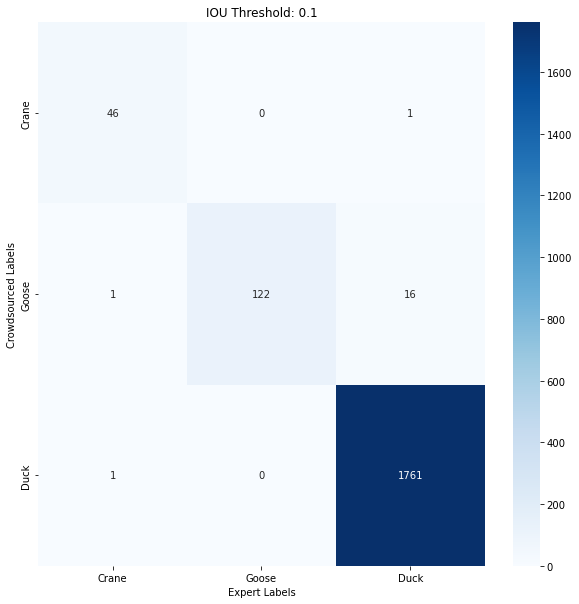

In [34]:
# chart the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Add labels and title
ax.set_xlabel('Expert Labels')
ax.set_ylabel('Crowdsourced Labels')
ax.set_title('IOU Threshold: 0.1')

# Add class names as tick labels
ax.set_xticklabels(list(class_map2.values()))
ax.set_yticklabels(list(class_map1.values()))

plt.show()